# Transfer learning and File-Tunining

- How to classify images of cats and dogs by using transfer learning from a pre-trained network

- Two ways to customer a pretained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simple add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

You do not need to (re)train the entire model. The base convolutional network already contains features that generically usefull for classifying pictures. However, the final classification part of pretrained model is specific to the original classfication task, and subsequently specific  to the set of classes on which the model was trained.

2. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

### Importing

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2025-04-04 20:43:28.533804: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 20:43:28.944282: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 20:43:29.293442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743779609.656351    5848 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743779609.739519    5848 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743779610.431748    5848 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# glob.glob(f"{PATH}/cats_and_dogs_extracted/cats_and_dogs_filtered/*")

### Data preprocessing

#### Data Download

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file("cats_and_dogs.zip", origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), r"cats_and_dogs_extracted/cats_and_dogs_filtered/")

train_dir = os.path.join(PATH, "train")
validation_dr = os.path.join(PATH, "validation")

if not os.path.exists(train_dir) or not os.path.exists(validation_dr):
    raise FileNotFoundError("Unable to located dataset")

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size = IMG_SIZE
)

Found 2000 files belonging to 2 classes.


2025-04-04 20:43:52.830128: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dr,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 1000 files belonging to 2 classes.


The first nine images and labels from the training set:

2025-04-04 20:43:53.872052: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


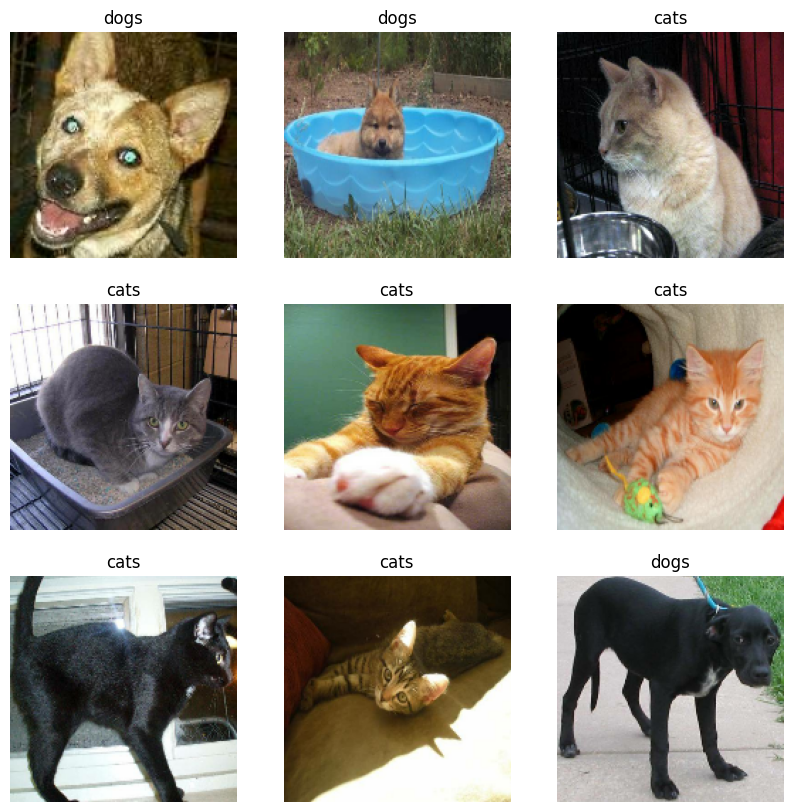

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The original dataset doesn't contain a test set, we'lll create one.

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print("Number of validation batches: %d" % tf.data.experimental.cardinality(validation_dataset))
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


#### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### Use data augmentation

When you don't have a large image dataset, it's a good practice to articially introduce sample diversity by apply random, yet realistc, transformations to the training images, such as rotation and horizontal flip

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

Let's repeatedly apply these alyers to the same image and see the result.

2025-04-04 20:43:58.169844: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


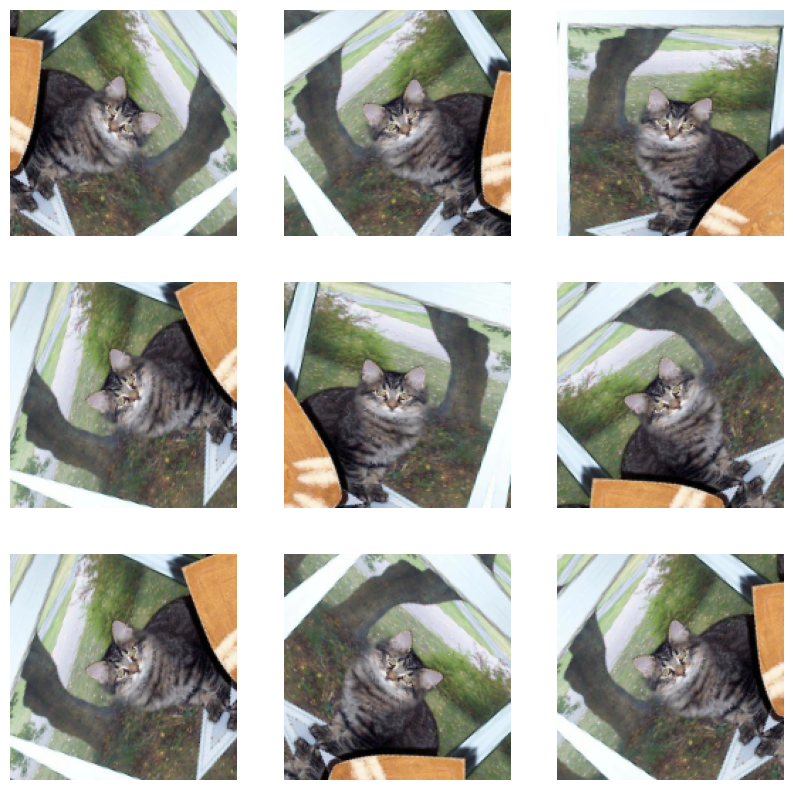

In [10]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Rescale pixel values

Will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, this pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Create the base model from the pretrained convnets

Will crate the base model from the **MobileNet V2** model developed at Google. This pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, we need to pick which layer of MobileNet V2 we will use for feature extraction. This very last classficitation lyer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument,you load a network that dones't include the classification layers at the top, which is ideal for the feature extraction

In [13]:
# create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet"
)

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch)

tf.Tensor(
[[[[0.00000000e+00 2.13887072e+00 0.00000000e+00 ... 0.00000000e+00
    1.65541124e+00 0.00000000e+00]
   [1.05211043e+00 4.63490915e+00 0.00000000e+00 ... 0.00000000e+00
    1.06893301e+00 0.00000000e+00]
   [8.62780333e-01 4.84911013e+00 0.00000000e+00 ... 0.00000000e+00
    1.24655676e+00 0.00000000e+00]
   [1.40211606e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]]

  [[0.00000000e+00 3.74075460e+00 2.74916649e-01 ... 0.00000000e+00
    1.04998779e+00 0.00000000e+00]
   [1.42374396e+00 6.00000000e+00 1.70461464e+00 ... 0.00000000e+00
    2.74485111e-01 8.32662582e-02]
   [2.19952130e+00 6.00000000e+00 6.01917267e-01 ... 0.00000000e+00
    0.00000000e+00 1.05441761e+00]
   [2.85281730e+00 4.43869162e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000

### Feature extraction

In this step, you will freeze the convolutional base before you compile and train the model. Freezing prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so letting  the entire model's `trainable` flag to False will freeze all of them. 

In [15]:
base_model.trainable = False 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, ou should keep the BatchNormalization layers in inference model by passing `training=False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [16]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

##### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to a single 1280-element vector per image.

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Position numbers predict class 1, negative numbers predict class 0.

In [18]:
prediction_layer = tf.keras.layers.Dense(1, activation="sigmoid")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the Keras Function API.

In [19]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand *trainable* parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [21]:
len(model.trainable_variables)

2

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


##### Compile the model

Compile the model before training it. Since there are two classes and a sigmoid output, use the `BinaryAccuracy`.

In [23]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy,
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            threshold=0.5,
            name='accuracy'
        )
    ]
)

##### Train the model

After training for 10 epochs, you should see ~96% accuracy on the validation set.

In [24]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 576ms/step - accuracy: 0.5391 - loss: 0.7340


In [25]:
print('initial loss: {:.2f}'.format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.73
initial accuracy: 0.55


In [26]:
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 602ms/step - accuracy: 0.5474 - loss: 0.7479 - val_accuracy: 0.7884 - val_loss: 0.5000
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 593ms/step - accuracy: 0.7412 - loss: 0.5229 - val_accuracy: 0.9010 - val_loss: 0.3631
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 559ms/step - accuracy: 0.8176 - loss: 0.4288 - val_accuracy: 0.9307 - val_loss: 0.2874
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 569ms/step - accuracy: 0.8591 - loss: 0.3661 - val_accuracy: 0.9480 - val_loss: 0.2304
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 562ms/step - accuracy: 0.8715 - loss: 0.3174 - val_accuracy: 0.9579 - val_loss: 0.1985
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 569ms/step - accuracy: 0.9006 - loss: 0.2862 - val_accuracy: 0.9629 - val_loss: 0.1743
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 545ms/step - accuracy: 0.8936 - loss: 0.2690 - val_accuracy: 0.9641 - val_loss: 0.1595
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.9035 - loss: 0.2582 - val_accu

##### Learninig curves

Let's take a look at the learning curve of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

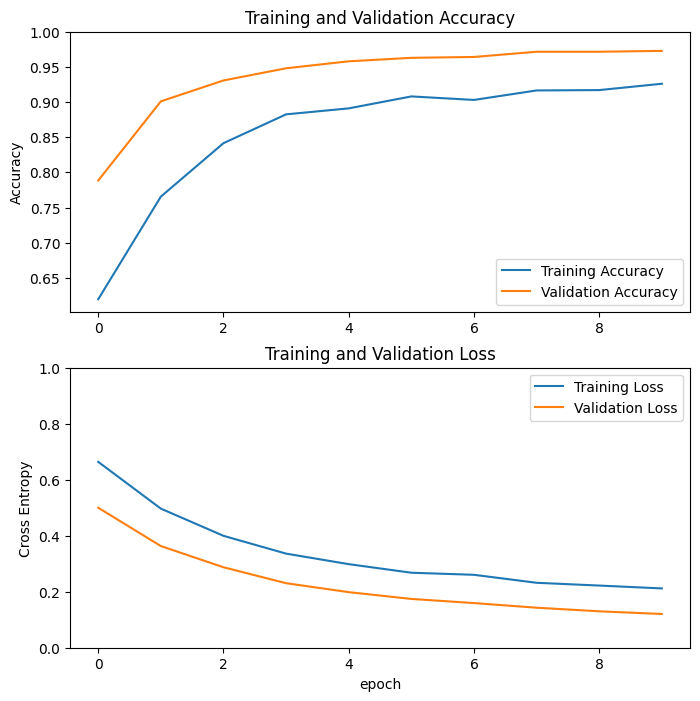

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

### Fine tuning

In the feature extraction experiment, you only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance event further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specially with the dataset.

Also, we should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it it. The first few layers learn very simple and generic features that generialize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of the fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

#### Un-freeze the top layers of the model

All we need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, we should recompile the model (necessary for these changes to take effect), and resume training. 

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model:", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model: 154


##### Compile the model

As we are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, our model could overfit very quickly.

In [32]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy,
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate=base_learning_rate/10
    ),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            threshold=0.5,
            name='accuracy'
        )
    ]
)

In [33]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [34]:
len(model.trainable_variables)

56

##### Continue training the model

If we trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [36]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=validation_dataset
)

Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 788ms/step - accuracy: 0.8011 - loss: 0.4066 - val_accuracy: 0.9790 - val_loss: 0.0766
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 728ms/step - accuracy: 0.8971 - loss: 0.2699 - val_accuracy: 0.9777 - val_loss: 0.0670
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 928ms/step - accuracy: 0.9052 - loss: 0.2278 - val_accuracy: 0.9814 - val_loss: 0.0573
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 894ms/step - accuracy: 0.9326 - loss: 0.1901 - val_accuracy: 0.9765 - val_loss: 0.0547
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 780ms/step - accuracy: 0.9328 - loss: 0.1749 - val_accuracy: 0.9802 - val_loss: 0.0502
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 783ms/step - accuracy: 0.9306 - loss: 0.1615 - val_accuracy: 0.9827 - val_loss: 0.0476
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 990ms/step - accuracy: 0.9443 - loss: 0.1465 - val_accuracy: 0.9814 - val_loss: 0.0495
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 73s 841ms/step - accuracy: 0.9449 - loss: 0.1316 - 

Let's take a look at the learning curves of the training and validation accuracy/loss when the fine-tuning the last layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.

After the tuning  the model nearly reaches 98% accuracy on the validation set.

In [38]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

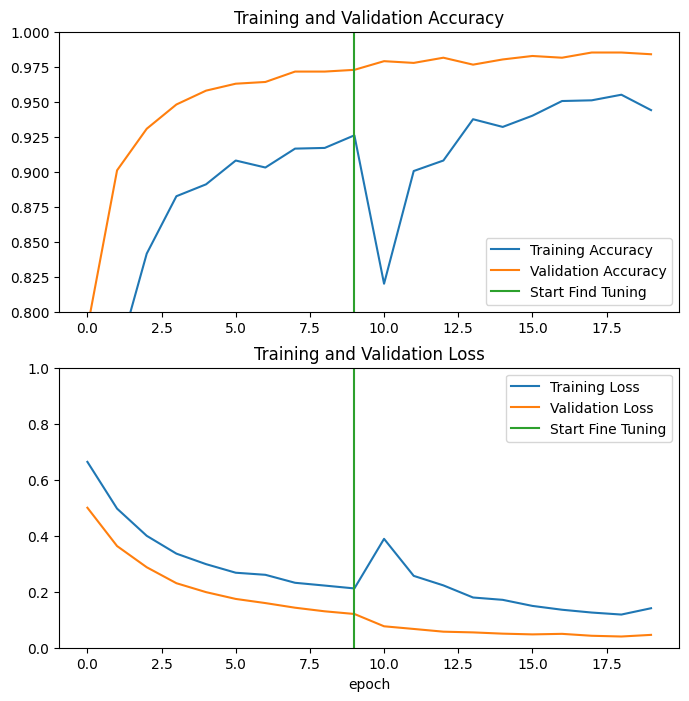

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Find Tuning")
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

### Evaluation and prediction

Finally we can verify the performance of the model on new data using test set.

In [43]:
loss, accuracy = model.evaluate(test_dataset)
print("Test accuracy: ", accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 393ms/step - accuracy: 0.9878 - loss: 0.0338
Test accuracy:  0.9895833134651184


And now we are all set to use this model to predict if your pet is a cat or dog.

Predictions: 
 [0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 0]
Labels:
 [0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0]


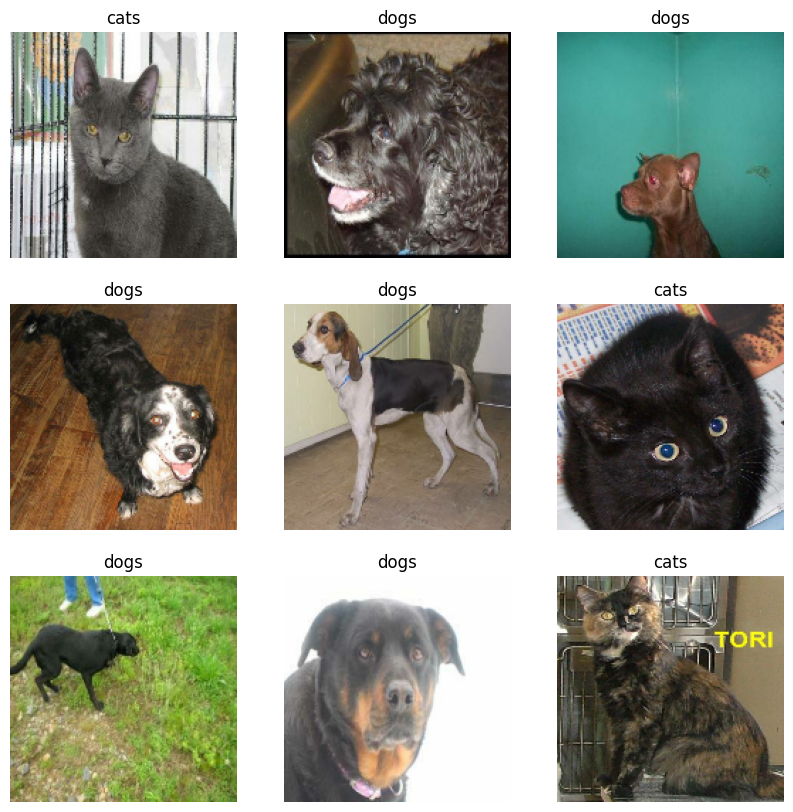

In [44]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions: \n", predictions.numpy())
print("Labels:\n", label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")